<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/SL_Policy_Training_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/OTHELLO

/content/drive/MyDrive/OTHELLO


In [3]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

import matplotlib.patches as pat
import seaborn as sns

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(77)

# Datset

In [4]:
#DEBUG = True

#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
#data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
#cols = [ i for i in range(64)]
#data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
#data = data.drop_duplicates()
#data.to_csv('drop_dups.csv', index=False)
#
#if DEBUG:
#    data = data.sample(n=10000)

data = pd.read_csv('drop_dups.csv')
gc.collect()

print(data.shape)
data.head()

(3356857, 68)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,W,59
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,W,57
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,W,55
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,W,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,3,W,51


In [5]:
# 盤面を渡すと、今回置ける場所を返してくれる
# 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所

def check(board): #今回の手番の人が打てる場所をリストアップする
    okeru_list = []
    for x in range(8):
        for y in range(8):
            plc = board[y, x]
            if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                able = octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                    okeru_list.append([x,y])
    return okeru_list
  
def octpass(basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
    basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

    if board[basho[1], basho[0]] != 0:
        print('既に石が置かれています')
    else:
        for x in [-1,0,1]:
            for y in [-1,0,1]: #8方向を順に見ていく
                tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                if x == 0 and y == 0:
                    pass #方向がないときはパスする

                for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                    if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                        check_plc = board[basho[1]+y*length, basho[0]+x*length]
                        if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                            break
                        elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                            tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                        elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                            if len(tmp) > 0: #中身がからでない場合のみ
                                basho_list |= set(tmp)
                            break #手を伸ばすのを終了
    
                    else: #もし盤面を飛び出してしまうならpassする
                        pass
    return list(basho_list)

In [6]:
class OCDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)
        puttables = check(state)
        #for puttable_place in puttables:
        #    state_can[puttable_place[0], puttable_place[1]] = 1 # 現在の手番が石を置ける場所

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_on, state_op, state_my] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( self.action.iloc[idx], dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

# Check Dataset

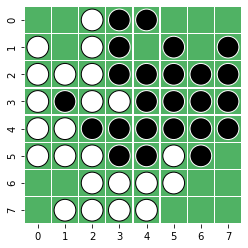

answer : [5, 7]
毎回黒手番です
[[0, 6], [1, 0], [1, 1], [1, 6], [5, 7], [6, 6], [6, 7]]


In [8]:
A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
states[0]

opp = (states[0][1]==1).detach().numpy().astype(np.uint8)*-1
my  = (states[0][2]==1).detach().numpy().astype(np.uint8)
table = opp + my

#table = data.iloc[idx, :64].values.reshape(8,8)
#actions = data.iloc[idx, [64, 65]]
#color = data.iloc[idx, 66]

def plt_img(state, show_num=False):
    fig, axes= plt.subplots(1, 1)
    back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, cmap='Greens', linewidths=0.3, cbar=False, vmin=0,vmax=255)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            if show_num:
                axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

plt_img(table)

action = action[0].detach().numpy()
basho = [action%8, action//8]

print("answer :", basho)
#print(color)
print('毎回黒手番です')
print(check(table))

A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
#print(states[0])

plt.imshow( states[0].numpy().transpose(1,2,0) ,extent=(0,8,0,8), cmap='bwr')
plt.xticks([0,1,2,3,4,5,6,7,8])
# x軸に補助目盛線を設定
plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

# y軸に目盛線を設定
plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)
print(action[0])
print( "y :",action[0]//8 +1 )
print( "x :",action[0]%8 +1 )
print(color[0]) 
print('常に緑の手番ということになってます')
print('赤が今回緑の人が置ける場所')

# Model

In [ ]:
class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.flatten = nn.Flatten()

        self.pi_net = nn.Linear(64*8*8, 64)
        self.pi_act = nn.Softmax()

        self.V_net = nn.Linear(64*8*8, 1)

    def forward(self, x):
        x  = self.relu(self.bn1(self.conv1(x)))
        x  = self.relu(self.bn2(self.conv2(x)))
        x  = self.relu(self.bn3(self.conv3(x)))
        x  = self.relu(self.bn4(self.conv4(x)))
        x  = self.flatten(x)
        pi = self.pi_act( self.pi_net(x) )
        V  = self.V_net(x)
        return pi, V

In [9]:
class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*8*8, 64)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        return x, _

# Training

In [10]:
def get_folds(NUM_FOLDS=5, data=data):
    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    folds = np.ones(data.shape[0])

    for i, (trn_idx, val_idx) in enumerate(kfold.split(data)):
        folds[val_idx] = i
    return folds

def get_loaders(df, folds, n_fold):
    trn_df = df[(folds!=n_fold)]
    val_df = df[(folds==n_fold)]

    trn_dataset = OCDataset(trn_df)
    val_dataset = OCDataset(val_df)

    trn_loader = DataLoader(
        dataset = trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        dataset = val_dataset,
        batch_size = BATCH_SIZE,
        shuffle=False
    )
    return trn_loader, val_loader

In [14]:
def train_fn(model, optim, trn_loader, metrics):
    train_loss = 0
    accs = []
    for table, action, _ in tqdm(trn_loader):
        model.train()
        optim.zero_grad()
        table   = table.to(DEVICE)
        action = action.to(DEVICE)
        pi_value, V_value = model(table)
        #loss  = metrics( torch.log(pi_value), action )
        loss  = metrics( pi_value, action )
        loss.backward()
        optim.step()

        train_loss += loss.cpu().detach().numpy()
        acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pi_value.cpu().detach().numpy(), axis=1  ))
        accs.append(acc)
    return train_loss / len(trn_loader), np.mean(accs)

def valid_fn(model, val_loader, metrics):
    valid_loss = 0
    accs = []
    for table, action, _ in  tqdm(val_loader):
        with torch.no_grad():
            model.eval()
            table   = table.to(DEVICE)
            action = action.to(DEVICE)
            pi_value, V_value = model(table)
            loss  = metrics(torch.log(pi_value), action)
            loss  = metrics( pi_value, action )

            valid_loss += loss.cpu().detach().numpy()
            acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pi_value.cpu().detach().numpy(), axis=1  ))
            accs.append(acc)
    return valid_loss/len(val_loader), np.mean(accs)

In [12]:
data2 = data.sample(500)

In [17]:
EPOCHS = 15
BATCH_SIZE = 16
DEVICE = 'cpu'
metrics = nn.CrossEntropyLoss()
#metrics = nn.NLLLoss()

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

folds = get_folds(NUM_FOLDS=5, data=data2)
trn_loader, val_loader = get_loaders(data2, folds, 0)
model = CNN_Brain().to(DEVICE)

#model_path = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_7.pth"
#model.load_state_dict(torch.load(model_path))
optim = Adam(params=model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):  
    train_loss = 0
    train_loss, train_acc = train_fn(model, optim, trn_loader, metrics)
    valid_loss, valid_acc = valid_fn(model, val_loader, metrics)

    print("="*30)
    print(f"epoch is {epoch}")
    print('train_loss :', train_loss)
    print('train_acc :', train_acc)
    print('valid_loss :', valid_loss)
    print('valid_acc :', valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    model_path = f"./SL_models/SL_Network_1_epoch_{epoch+8}.pth"
    #torch.save(model.state_dict(), model_path)


epoch is 0
train_loss : 4.52778564453125
train_acc : 0.0275
valid_loss : 3.9869426659175327
valid_acc : 0.017857142857142856



epoch is 1
train_loss : 1.9545102500915528
train_acc : 0.62
valid_loss : 4.07267393384661
valid_acc : 0.03571428571428571



epoch is 2
train_loss : 0.6606890225410461
train_acc : 0.985
valid_loss : 4.272259065083095
valid_acc : 0.044642857142857144



epoch is 3
train_loss : 0.19849864274263382
train_acc : 1.0
valid_loss : 4.341704300471714
valid_acc : 0.05357142857142857



epoch is 4
train_loss : 0.07894443556666374
train_acc : 1.0
valid_loss : 4.376430681773594
valid_acc : 0.026785714285714284



epoch is 5
train_loss : 0.04833176389336586
train_acc : 1.0
valid_loss : 4.376840625490461
valid_acc : 0.026785714285714284



epoch is 6
train_loss : 0.03782569542527199
train_acc : 1.0
valid_loss : 4.391431910651071
valid_acc : 0.026785714285714284



epoch is 7
train_loss : 0.02860812172293663
train_acc : 1.0
valid_loss : 4.412326301847186
valid_acc : 0.026785714285714284



epoch is 8
train_loss : 0.02324188970029354
train_acc : 1.0
valid_loss : 4.430012771061489
valid_acc : 0.026785714285714284



epoch is 9
train_loss : 0.019812612161040306
train_acc : 1.0
valid_loss : 4.43477862221854
valid_acc : 0.03571428571428571



epoch is 10
train_loss : 0.016475624293088912
train_acc : 1.0
valid_loss : 4.4516898563929965
valid_acc : 0.026785714285714284



epoch is 11
train_loss : 0.014543804787099362
train_acc : 1.0
valid_loss : 4.455833060400827
valid_acc : 0.026785714285714284



epoch is 12
train_loss : 0.01243148349225521
train_acc : 1.0
valid_loss : 4.469478607177734
valid_acc : 0.03571428571428571



epoch is 13
train_loss : 0.01114840142428875
train_acc : 1.0
valid_loss : 4.479426145553589
valid_acc : 0.03571428571428571



epoch is 14
train_loss : 0.009877732507884502
train_acc : 1.0
valid_loss : 4.493057489395142
valid_acc : 0.03571428571428571


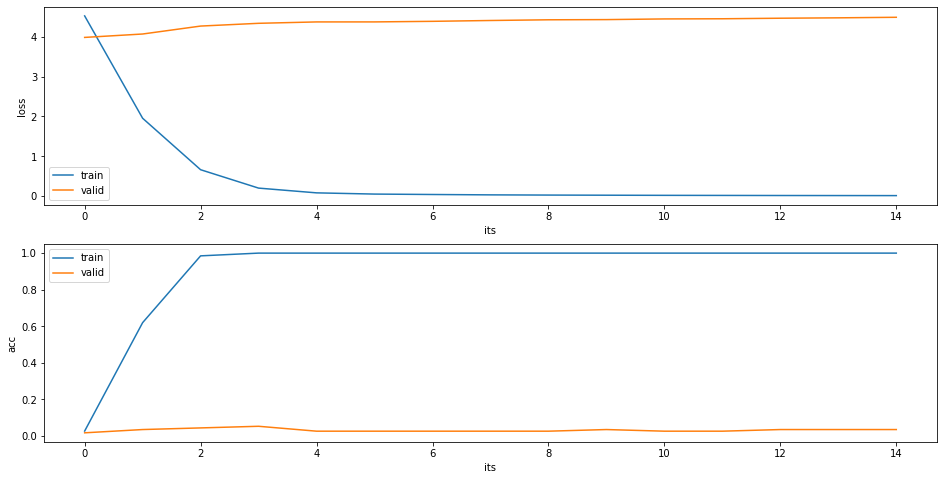

In [18]:
train_loss_hist = pd.DataFrame(train_losses)
train_acc_hist = pd.DataFrame(train_accs)
val_loss_hist = pd.DataFrame(valid_losses)
val_acc_hist = pd.DataFrame(valid_accs)
fig, axes = plt.subplots(2, 1, figsize = (16, 8))
axes[0].plot(train_loss_hist, label = "train")
axes[0].plot(val_loss_hist, label = "valid")
axes[0].legend(loc = "best")
axes[0].set_xlabel("its")
axes[0].set_ylabel("loss")
axes[1].plot(train_acc_hist, label = "train")
axes[1].plot(val_acc_hist, label = "valid")
axes[1].legend(loc = "best")
axes[1].set_xlabel("its")
axes[1].set_ylabel("acc")
plt.show()